# Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from imblearn import under_sampling, over_sampling
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score
from sklearn.metrics import confusion_matrix, roc_auc_score, f1_score, recall_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Load Data and Preliminary Look

In [2]:
# Load the data
train = pd.read_csv('train.csv')
train.head()

,id,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,Male,44,1,28.0,0,> 2 Years,Yes,40454.0,26.0,217,1
1,2,Male,76,1,3.0,0,1-2 Year,No,33536.0,26.0,183,0
2,3,Male,47,1,28.0,0,> 2 Years,Yes,38294.0,26.0,27,1
3,4,Male,21,1,11.0,1,< 1 Year,No,28619.0,152.0,203,0
4,5,Female,29,1,41.0,1,< 1 Year,No,27496.0,152.0,39,0


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 381109 entries, 0 to 381108
Data columns (total 12 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    381109 non-null  int64  
 1   Gender                381109 non-null  object 
 2   Age                   381109 non-null  int64  
 3   Driving_License       381109 non-null  int64  
 4   Region_Code           381109 non-null  float64
 5   Previously_Insured    381109 non-null  int64  
 6   Vehicle_Age           381109 non-null  object 
 7   Vehicle_Damage        381109 non-null  object 
 8   Annual_Premium        381109 non-null  float64
 9   Policy_Sales_Channel  381109 non-null  float64
 10  Vintage               381109 non-null  int64  
 11  Response              381109 non-null  int64  
dtypes: float64(3), int64(6), object(3)
memory usage: 34.9+ MB


Data description :

**id**: Unique ID for the customer

**Gender**: Gender of the customer

**Age**: Age of the customer

**Driving_License** 0 : Customer does not have DL, 1 : Customer already has DL

**Region_Code**: Unique code for the region of the customer

**Previously_Insured** 1 : Customer already has Vehicle Insurance, 0 : Customer doesn't have Vehicle Insurance

**Vehicle_Age**: Age of the Vehicle

**Vehicle_Damage** 1 : Customer got his/her vehicle damaged in the past. 0 : Customer didn't get his/her vehicle damaged in the past.

**Annual_Premium** : The amount customer needs to pay as premium in the year

**PolicySalesChannel**: Anonymized Code for the channel of outreaching to the customer ie. Different Agents, Over Mail, Over Phone, In Person, etc.

**Vintage**: Number of Days, Customer has been associated with the company

**Response** 1 : Customer is interested, 0 : Customer is not interested

# Data Cleaning

In [4]:
# Check missing value
train.isnull().sum()

id                      0
Gender                  0
Age                     0
Driving_License         0
Region_Code             0
Previously_Insured      0
Vehicle_Age             0
Vehicle_Damage          0
Annual_Premium          0
Policy_Sales_Channel    0
Vintage                 0
Response                0
dtype: int64

In [5]:
# Check duplicated value
train.duplicated().sum()

0

In [6]:
# Drop unnecessary column
train = train.drop('id', axis=1)

the data have been clean up. there is no missing and duplicated value and alsa had drop unnecessary column

# EDA

## Statistical summary

In [7]:
# Group columns by their types
nums = ['Age', 'Driving_License', 'Region_Code', 'Previously_Insured',
        'Annual_Premium', 'Policy_Sales_Channel', 'Vintage', 'Response']
cats = ['Gender', 'Vehicle_Age', 'Vehicle_Damage']

In [8]:
# statistical summary numeric columns
train[nums].describe()

,Age,Driving_License,Region_Code,Previously_Insured,Annual_Premium,Policy_Sales_Channel,Vintage,Response
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,38.822584,0.997869,26.388807,0.458210,30564.389581,112.034295,154.347397,0.122563
std,15.511611,0.046110,13.229888,0.498251,17213.155057,54.203995,83.671304,0.327936
min,20.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000,0.000000
25%,25.000000,1.000000,15.000000,0.000000,24405.000000,29.000000,82.000000,0.000000
50%,36.000000,1.000000,28.000000,0.000000,31669.000000,133.000000,154.000000,0.000000
75%,49.000000,1.000000,35.000000,1.000000,39400.000000,152.000000,227.000000,0.000000
max,85.000000,1.000000,52.000000,1.000000,540165.000000,163.000000,299.000000,1.000000


dari kesimpulan statistik kolom numerik diketahui bahwa :

- kolom driving_license, previously_insured, dan Response merupakan value binary
- secara keseluruhan kolom terdistribusi baik
- persebaran min max annual_premium sangat jauh

In [9]:
# statistical summary categoric columns
train[cats].describe()

,Gender,Vehicle_Age,Vehicle_Damage
count,381109,381109,381109
unique,2,3,2
top,Male,1-2 Year,Yes
freq,206089,200316,192413


## Rasio Customer Response

In [10]:
# count cust group by which has interest and not
response = train['Response'].value_counts()
response

0    334399
1     46710
Name: Response, dtype: int64

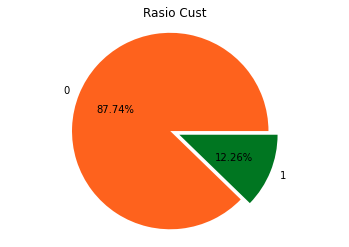

In [11]:
# proportion interest cust
label = response.index
count = response.values
colors=['#fe621d', '#007621']
explode = (0, 0.1)

plt.title('Rasio Cust')
plt.pie(count, labels=label, colors=colors, explode=explode,
        autopct='%1.2f%%')
plt.axis('equal')
plt.show()

## Age feature

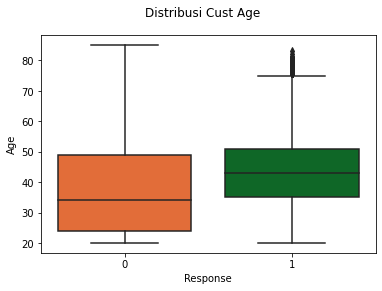

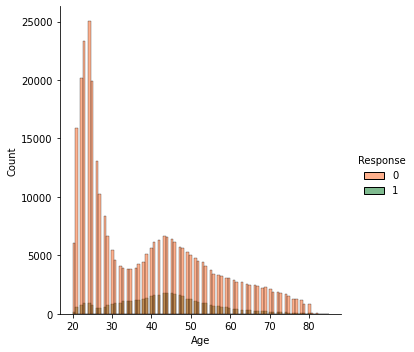

In [12]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Cust Age')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Response'], palette=palette)
plt.show()

In [13]:
def group_ages(x) :
  if x <= 25 :
    return 'Young'
  elif x > 25 and x < 45 :
    return 'Adult'
  elif x >= 45 and x < 60 :
    return 'Middle Age'
  else :
    return 'Elder'

referensi : https://www.researchgate.net/publication/338842581_A_cross-sectional_study_on_interference_control_age_affects_reactive_control_but_not_proactive_control

In [14]:
train_copy = train.copy()
train_copy['group_ages'] = train_copy['Age'].apply(group_ages)

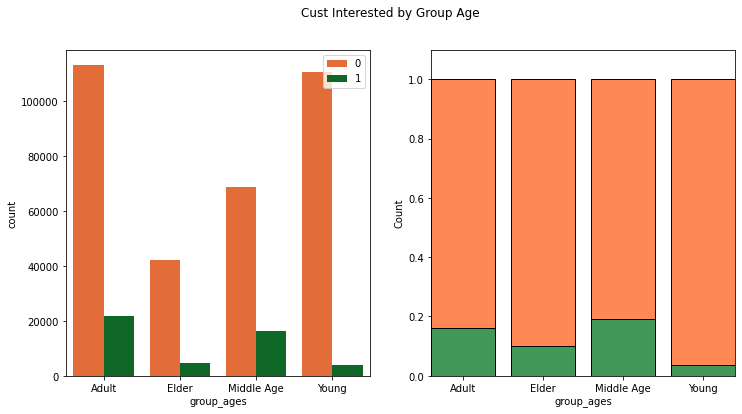

In [15]:
# cek berapa dan probability cust interested by group age
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Cust Interested by Group Age')

sns.countplot(ax=ax[0], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Response'], stat='count', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :
- middle age
- dan adult 

mempunyai probabilitas lebih untuk tertarik ke dalam vehicle insurance. selanjutnya akan cari informasi pendukung untuk menunjang hal tersebut

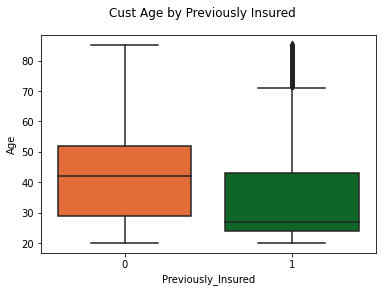

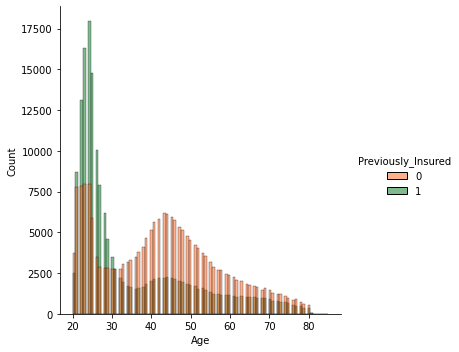

In [16]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Cust Age by Previously Insured')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Previously_Insured'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Previously_Insured'], palette=palette)
plt.show()

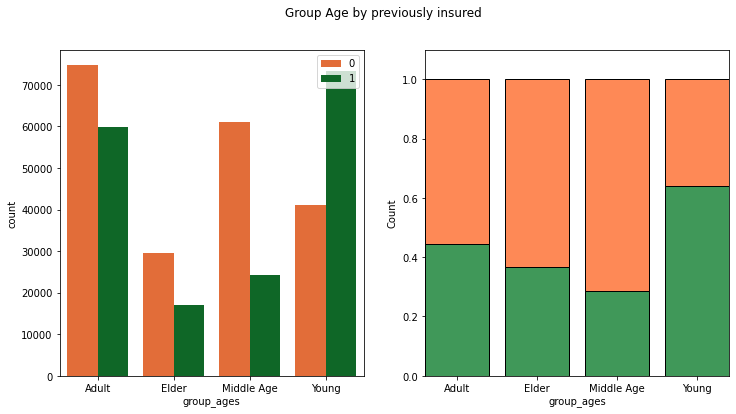

In [17]:
# cek penyebab di beberapa group age memiliki minat berdasar previously insured
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by previously insured')

sns.countplot(ax=ax[0], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Previously_Insured'], stat='count', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :
- kenapa young age tidak berminat karena mereka sudah memiliki vehicle insurance sebelumnya.
- di lain sisi kenapa middle age memiliki minat memang karena sebelumnya sedikit yang memiliki vehicle insurance.

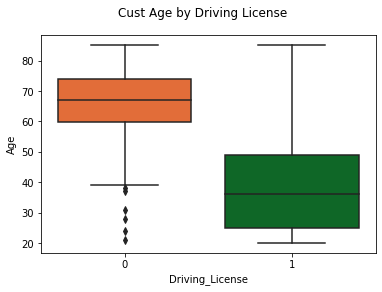

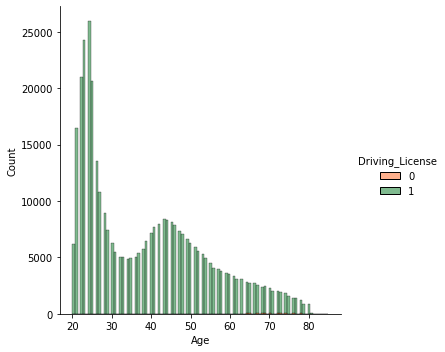

In [18]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Cust Age by Driving License')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Driving_License'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Driving_License'], palette=palette)
plt.show()

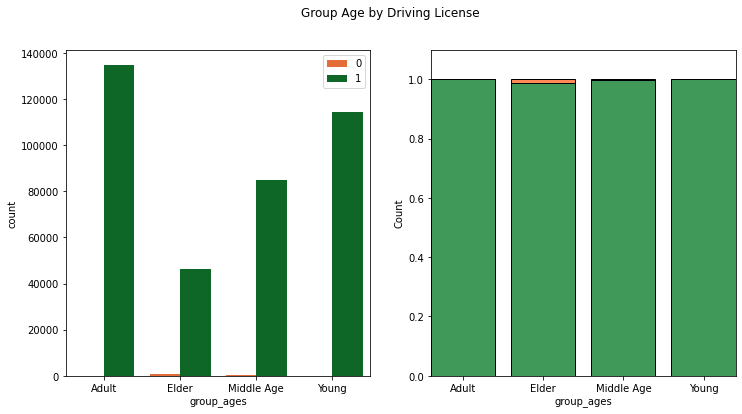

In [19]:
# cek penyebab di beberapa group age memiliki minat berdasar previously insured
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by Driving License')

sns.countplot(ax=ax[0], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Driving_License'], stat='count', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

sedikit terlihat bahwa kenapa elder tidak berminat dikarenakan adanya kemungkinan bahwa elder tidak semua memiliki lisensi untuk berkendara

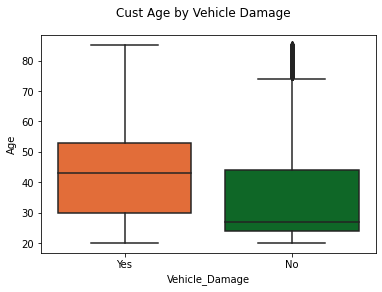

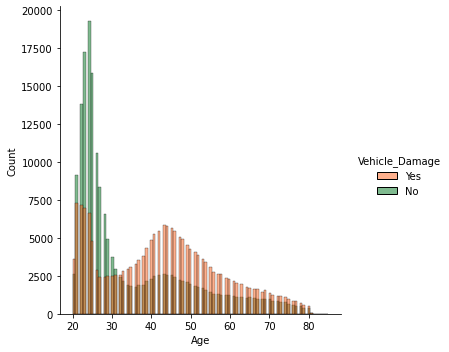

In [20]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Cust Age by Vehicle Damage')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Vehicle_Damage'], y=train['Age'], palette=palette)
sns.displot(x=train['Age'], hue=train['Vehicle_Damage'], palette=palette)
plt.show()

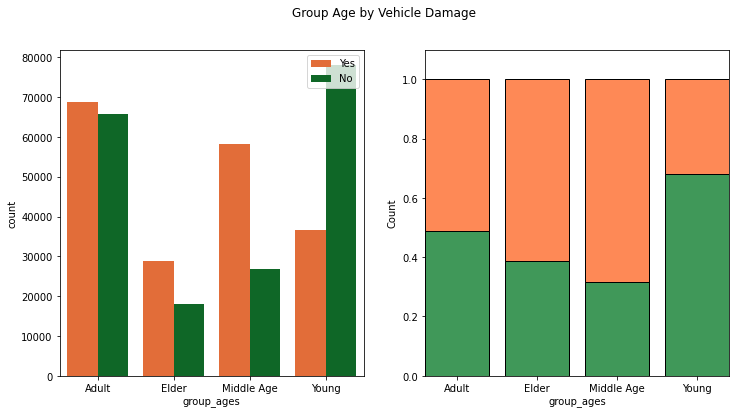

In [21]:
# cek penyebab di beberapa group age memiliki minat berdasar vehicle damage
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Group Age by Vehicle Damage')

sns.countplot(ax=ax[0], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train_copy, x=train_copy['group_ages'],
              hue=train_copy['Vehicle_Damage'], stat='count', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :
- grup young age memiliki probabilitas vehicle damage akan tetapi mereka sudah memiliki vehicle insurance.
- disini diketahui alasan bahwa grup adult berminat memiliki vehicle insurance karena mereka juga memiliki probabilitas vehicle damage.

## Annual premium feature

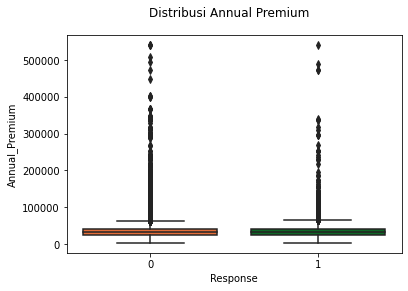

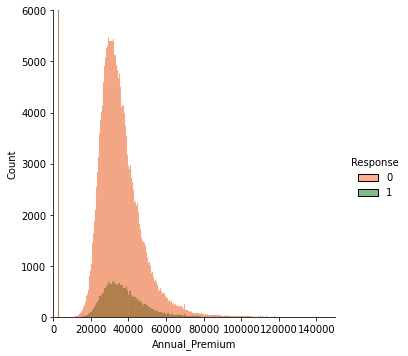

In [22]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Annual Premium')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Annual_Premium'], palette=palette)
sns.displot(x=train['Annual_Premium'], hue=train['Response'], palette=palette)
plt.ylim(0,6000)
plt.xlim(0,150000)
plt.show()

## Vintage feature

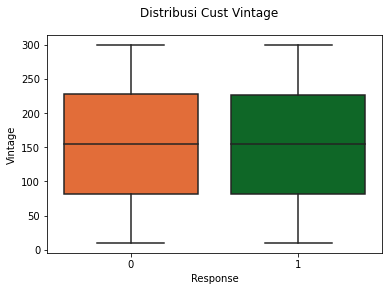

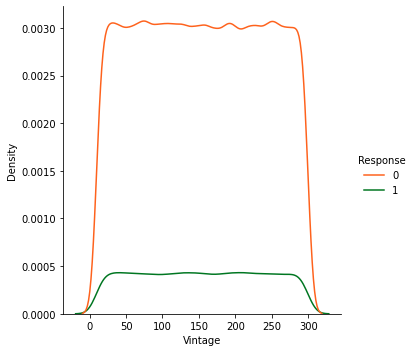

In [23]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Cust Vintage')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Vintage'], palette=palette)
sns.displot(x=train['Vintage'], hue=train['Response'], palette=palette, kind='kde')
plt.show()

## Policy sales channel feature

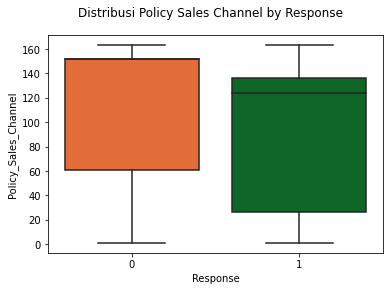

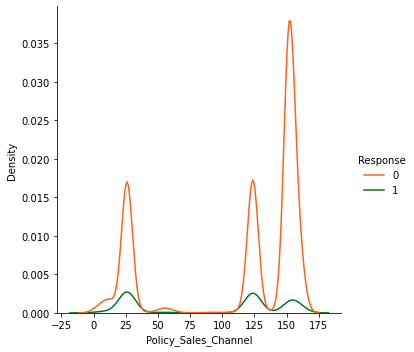

In [24]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Policy Sales Channel by Response')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Policy_Sales_Channel'], palette=palette)
sns.displot(x=train['Policy_Sales_Channel'], hue=train['Response'], palette=palette, kind='kde')
plt.show()

In [25]:
code_policy = train_copy.groupby(['Policy_Sales_Channel', 'Response']).agg(total=('Response', 'count'))

In [26]:
code_policy

total
Policy_Sales_Channel Response       
1.0                  0          1039
                     1            35
2.0                  0             3
                     1             1
3.0                  0           364
...                              ...
159.0                1             1
160.0                0         21304
                     1           475
163.0                0          2013
                     1           880

[274 rows x 1 columns]

In [27]:
pivot = pd.pivot_table(code_policy,
                      index='Policy_Sales_Channel',
                      columns='Response',
                      values='total',
                      aggfunc='sum')

In [28]:
pivot.head()

Response,0,1
Policy_Sales_Channel,,
1.0,1039.0,35.0
2.0,3.0,1.0
3.0,364.0,159.0
4.0,407.0,102.0
6.0,3.0,NaN


In [29]:
pivot.isnull().sum()

Response
0     2
1    34
dtype: int64

In [30]:
pivot[0].fillna(0, inplace=True)
pivot[1].fillna(0, inplace=True)

In [31]:
pivot.isnull().sum()

Response
0    0
1    0
dtype: int64

In [32]:
pivot['total'] = pivot[1] + pivot[0]
pivot['response_rate'] = pivot[1] / pivot['total'] * 100
pivot = pivot.round(2)
pivot.head()

Response,0,1,total,response_rate
Policy_Sales_Channel,,,,
1.0,1039.0,35.0,1074.0,3.26
2.0,3.0,1.0,4.0,25.00
3.0,364.0,159.0,523.0,30.40
4.0,407.0,102.0,509.0,20.04
6.0,3.0,0.0,3.0,0.00


In [33]:
# top 3 response by policy sales channel
pivot.sort_values(1, ascending=False).head(3)

Response,0,1,total,response_rate
Policy_Sales_Channel,,,,
26.0,63809.0,15891.0,79700.0,19.94
124.0,59999.0,13996.0,73995.0,18.91
152.0,130926.0,3858.0,134784.0,2.86


## Region Code feature

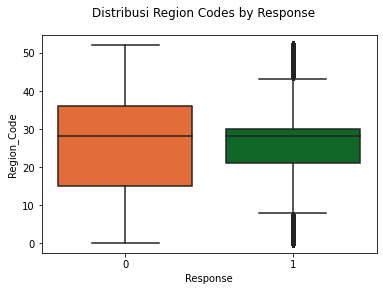

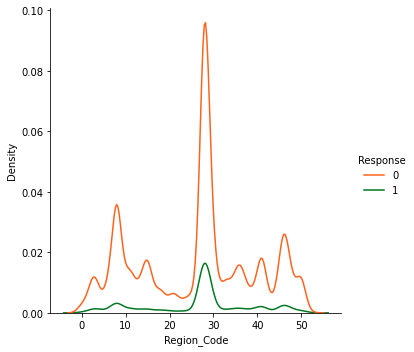

In [34]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Region Codes by Response')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Response'], y=train['Region_Code'], palette=palette)
sns.displot(x=train['Region_Code'], hue=train['Response'], palette=palette,kind='kde')
plt.show()

In [35]:
region_response = train_copy.groupby(['Region_Code', 'Response']).agg(total=('Response', 'count'))

In [36]:
rs_pivot = pd.pivot_table(region_response,
                      index='Region_Code',
                      columns='Response',
                      values='total',
                      aggfunc='sum')

In [37]:
rs_pivot['total'] = rs_pivot[1] + rs_pivot[0]
rs_pivot['response_rate'] = rs_pivot[1] / rs_pivot['total'] * 100
rs_pivot = rs_pivot.round(2)
rs_pivot.head()

Response,0,1,total,response_rate
Region_Code,,,,
0.0,1847,174,2021,8.61
1.0,899,109,1008,10.81
2.0,3751,287,4038,7.11
3.0,8070,1181,9251,12.77
4.0,1516,285,1801,15.82


In [38]:
# top 3 response by region code
rs_pivot.sort_values(1, ascending=False).head(3)

Response,0,1,total,response_rate
Region_Code,,,,
28.0,86498,19917,106415,18.72
8.0,30620,3257,33877,9.61
41.0,16039,2224,18263,12.18


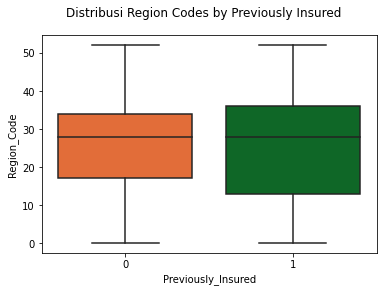

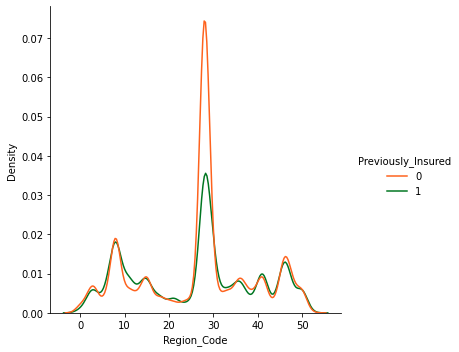

In [39]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Region Codes by Previously Insured')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Previously_Insured'], y=train['Region_Code'], palette=palette)
sns.displot(x=train['Region_Code'], hue=train['Previously_Insured'], palette=palette, kind='kde')
plt.show()

In [40]:
region_previous = train_copy.groupby(['Region_Code', 'Previously_Insured']).agg(
    total=('Previously_Insured', 'count'))

In [41]:
rp_pivot = pd.pivot_table(region_previous,
                      index='Region_Code',
                      columns='Previously_Insured',
                      values='total',
                      aggfunc='sum')

In [42]:
rp_pivot['total'] = rp_pivot[1] + rp_pivot[0]
rp_pivot['response_rate'] = rp_pivot[1] / rp_pivot['total'] * 100
rp_pivot = rp_pivot.round(2)
rp_pivot.head()

Previously_Insured,0,1,total,response_rate
Region_Code,,,,
0.0,1404,617,2021,30.53
1.0,682,326,1008,32.34
2.0,2079,1959,4038,48.51
3.0,4730,4521,9251,48.87
4.0,1047,754,1801,41.87


In [43]:
# top 3 region code by previously insured
rp_pivot.sort_values(0, ascending=False).head(3)

Previously_Insured,0,1,total,response_rate
Region_Code,,,,
28.0,73233,33182,106415,31.18
8.0,16770,17107,33877,50.50
46.0,9456,10293,19749,52.12


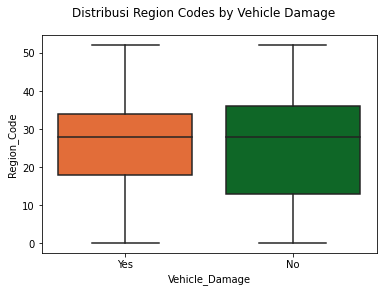

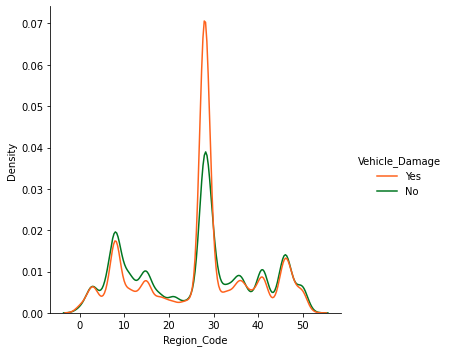

In [44]:
# Outlier check and data distributin
fig, ax = plt.subplots(figsize=(6,4))
fig.suptitle('Distribusi Region Codes by Vehicle Damage')
palette = ['#fe621d', '#007621']
sns.boxplot(x=train['Vehicle_Damage'], y=train['Region_Code'], palette=palette)
sns.displot(x=train['Region_Code'], hue=train['Vehicle_Damage'], palette=palette, kind='kde')
plt.show()

In [45]:
region_damage = train_copy.groupby(['Region_Code', 'Vehicle_Damage']).agg(total=('Vehicle_Damage', 'count'))

In [46]:
rd_pivot = pd.pivot_table(region_damage,
                      index='Region_Code',
                      columns='Vehicle_Damage',
                      values='total',
                      aggfunc='sum')

In [47]:
rd_pivot['total'] = rd_pivot['Yes'] + rd_pivot['No']
rd_pivot['damage_rate'] = rd_pivot['Yes'] / rd_pivot['total'] * 100
rd_pivot = rd_pivot.round(2)
rd_pivot.head()

Vehicle_Damage,No,Yes,total,damage_rate
Region_Code,,,,
0.0,837,1184,2021,58.58
1.0,378,630,1008,62.50
2.0,2199,1839,4038,45.54
3.0,4825,4426,9251,47.84
4.0,790,1011,1801,56.14


In [48]:
# top 3 region code by vehicle damage
rd_pivot.sort_values('Yes', ascending=False).head(3)

Vehicle_Damage,No,Yes,total,damage_rate
Region_Code,,,,
28.0,36179,70236,106415,66.00
8.0,18341,15536,33877,45.86
46.0,10890,8859,19749,44.86


## Previously Insured feature

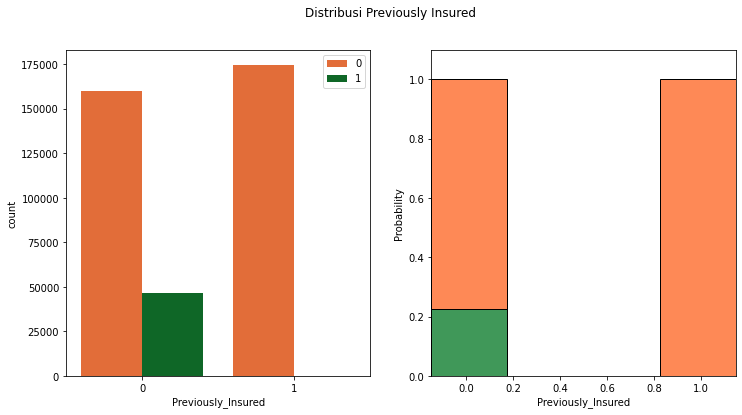

In [49]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Previously_Insured'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Previously_Insured'],
              hue=train['Response'], stat='probability', multiple='fill',
             shrink=12, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa mereka yang sebelumnya tidak memiliki vehicle insurance sebelumnya memiliki minat untuk bergabung.

## Driving License feature

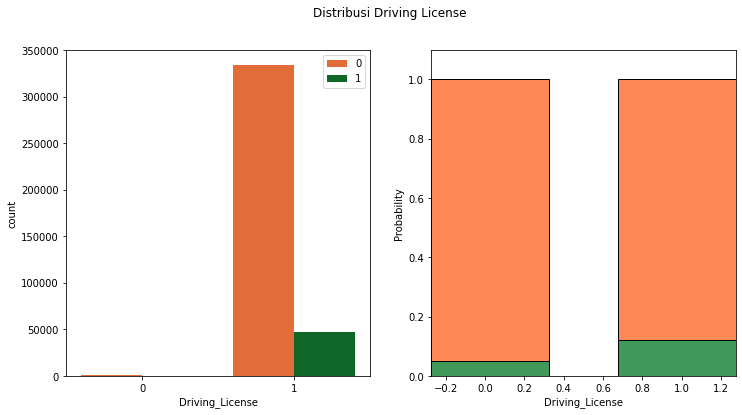

In [50]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Driving_License'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Driving_License'],
              hue=train['Response'], stat='probability', multiple='fill',
             shrink=12, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()	

berdasar informasi diatas terlihat bahwa jelas mereka memiliki lisensi berkendara memiliki probabilitas yang lebih tinggi untuk memiliki vehicle insurance.

## Gender feature

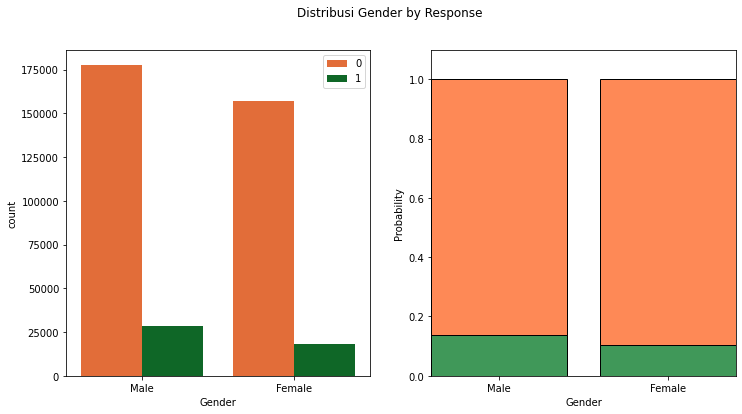

In [51]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Gender by Response')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Response'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()	

terlihat bahwa yang memiliki probabilitas yang lebih tinggi dibanding yang lain merupakan 'male'.

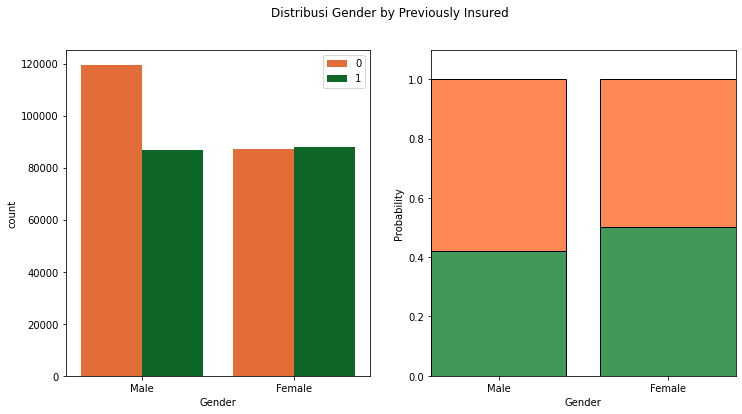

In [52]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Gender by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Previously_Insured'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat mengapa 'male' memiliki minat vehicle insurance karena mereka sebelumnya belum memilikinya dibanding 'female' mereka sudah memiliki vehicle insurance sebelumnya.

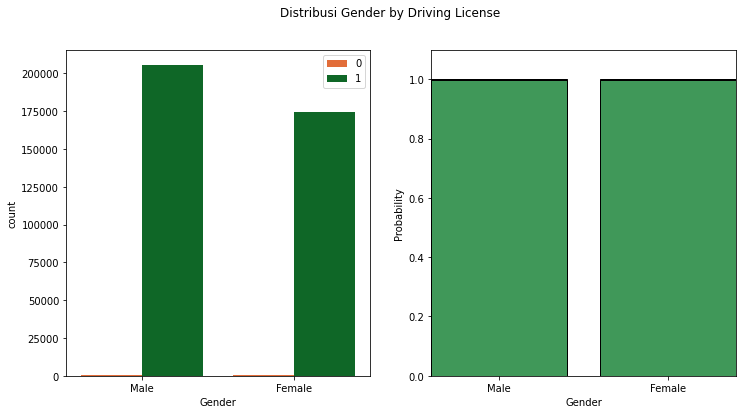

In [53]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Gender by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Driving_License'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

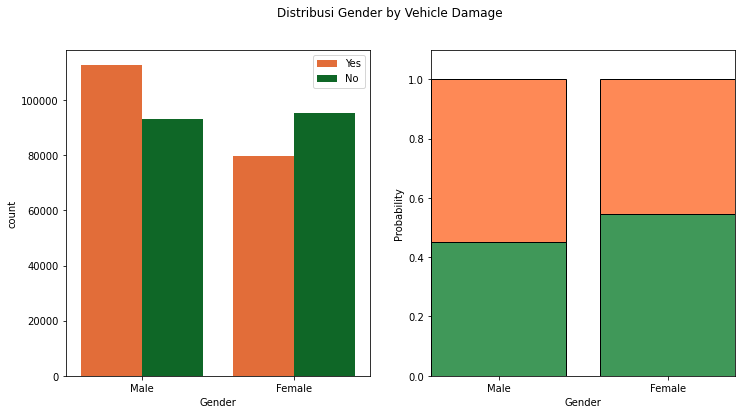

In [54]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Gender by Vehicle Damage')

sns.countplot(ax=ax[0], data=train, x=train['Gender'],
              hue=train['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Gender'],
              hue=train['Vehicle_Damage'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas diketahui bahwa :

- kalaupun 'female' probabilitas mengalami kerusakan akan tetapi mereka sudah memiliki vehicle insurance sebelumnya.
- probabilitas 'male' mengalami kerusakan lebih kecil akan tetapi mereka belum memiliki vehicle insurance sebelumnya.

## Vehicle Age feature

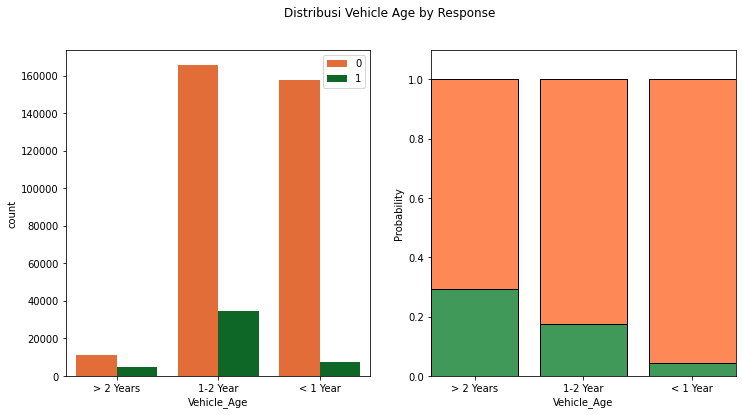

In [55]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Age by Response')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Response'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat bahwa kendaraan yang >= 1 tahun memiliki probabilitas yang lebih tinggi untuk memiliki vehicle insurance.

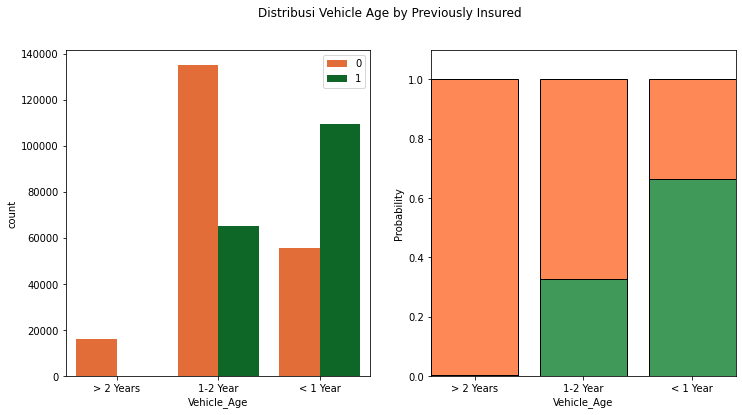

In [56]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Age by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Previously_Insured'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas bisa diketahui bahwa :
- kendaraan yang umurnya kurang dari 1 tahun sudah memiliki vehicle insurance
- kendaraan yang umurnya 1-2 tahun memiliki vehicle insurance sebelumnya tetapi lebih sedikit
- kendaraan yang umurnya lebih dari 2 tahun tidak memiliki vehicle insurance sebelumnya

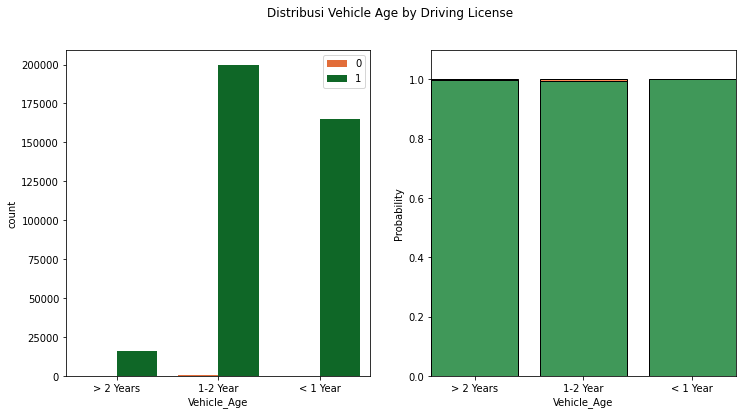

In [57]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Age by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Driving_License'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

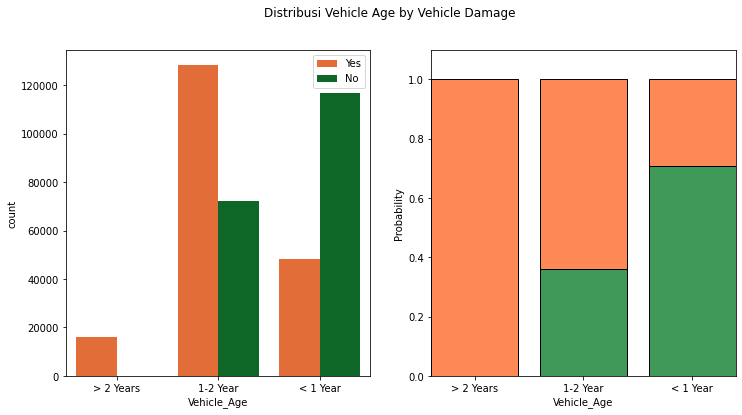

In [58]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Age by Vehicle Damage')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Vehicle_Damage'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Vehicle_Damage'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

berdasar informasi diatas bisa diketahui bahwa :
- akan tetapi kendaraan yang umurnya kurang dari 1 tahun lebih banyak mengalami vehicle damage
- kendaraan yang umurnya 1-2 tahun pernah mengalami vehicle damage tetapi lebih sedikit
- lebih baik kendaraan yang umurnya lebih dari 2 tahun jarang mengalami vehicle damage dan lebih menguntungkan jika bisa mendapat customer seperti ini.

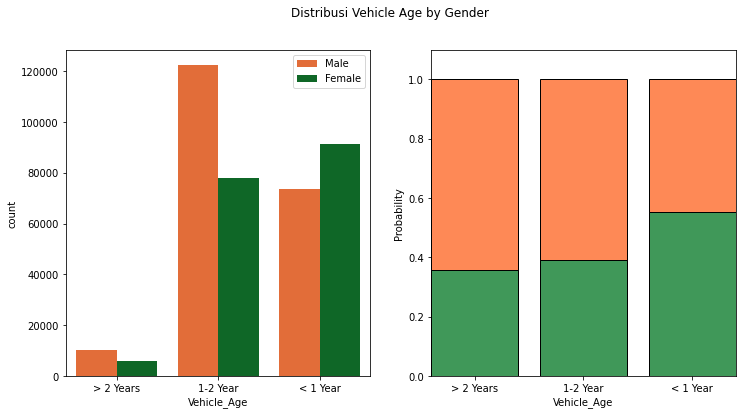

In [59]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Age by Gender')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Age'],
              hue=train['Gender'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Age'],
              hue=train['Gender'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat bahwa customer yang memiliki kendaraan lebih dari 2 tahun lebih banyak dimiliki oleh 'male'.

## Vehicle Damage feature

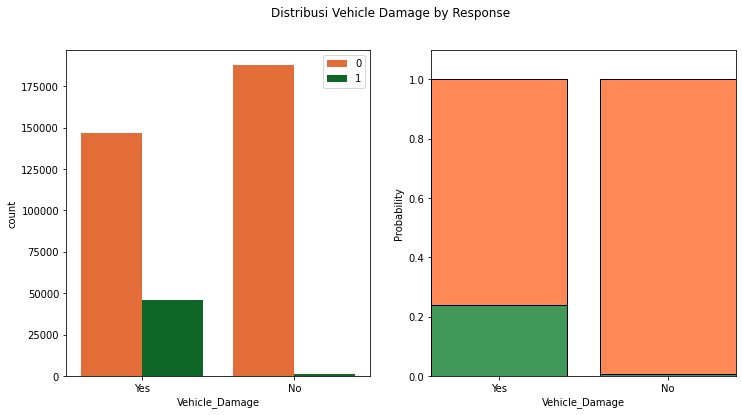

In [60]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Damage by Response')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Damage'],
              hue=train['Response'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Damage'],
              hue=train['Response'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

terlihat bahwa kendaraan yang pernah mengalami kerusakan sebelumnya memiliki probabilitas untuk memiliki vehicle insurance.

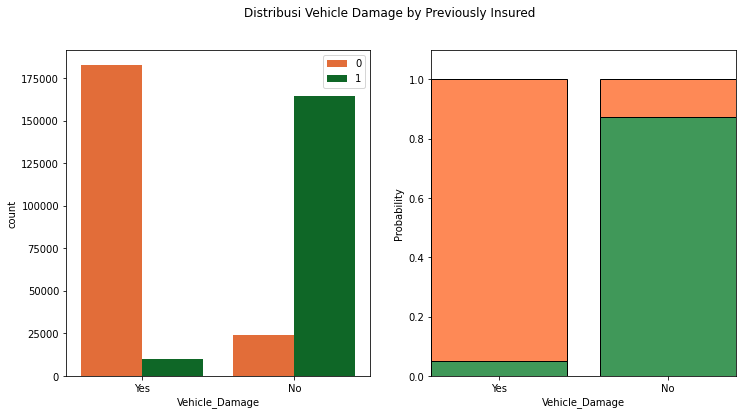

In [61]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Damage by Previously Insured')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Damage'],
              hue=train['Previously_Insured'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Damage'],
              hue=train['Previously_Insured'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

didukung bahwa kendaraan yang mengalami kerusakan sebelumnya juga tidak memiliki vehicle insurance sebelumnya

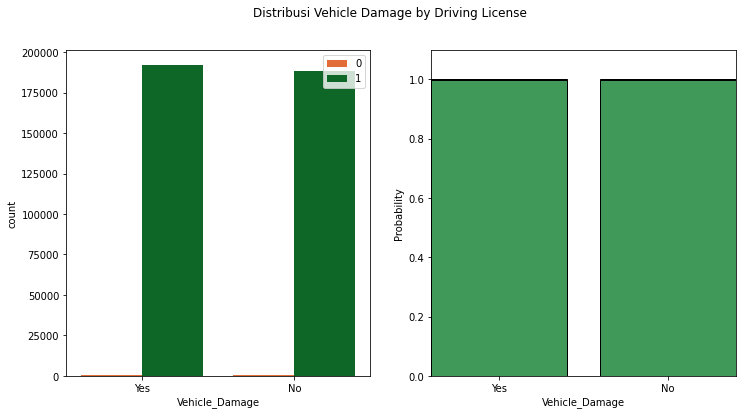

In [62]:
# proportion and probabilty check
fig, ax = plt.subplots(1,2,figsize=(12,6))
palette = ['#fe621d', '#007621']
fig.suptitle('Distribusi Vehicle Damage by Driving License')

sns.countplot(ax=ax[0], data=train, x=train['Vehicle_Damage'],
              hue=train['Driving_License'], palette=palette)
sns.histplot(ax=ax[1], data=train, x=train['Vehicle_Damage'],
              hue=train['Driving_License'], stat='probability', multiple='fill',
             shrink=.8, legend=False, palette=palette)
ax[0].legend(loc='upper right')
ax[1].set_ylim(0,1.1)
plt.show()

## Correlation

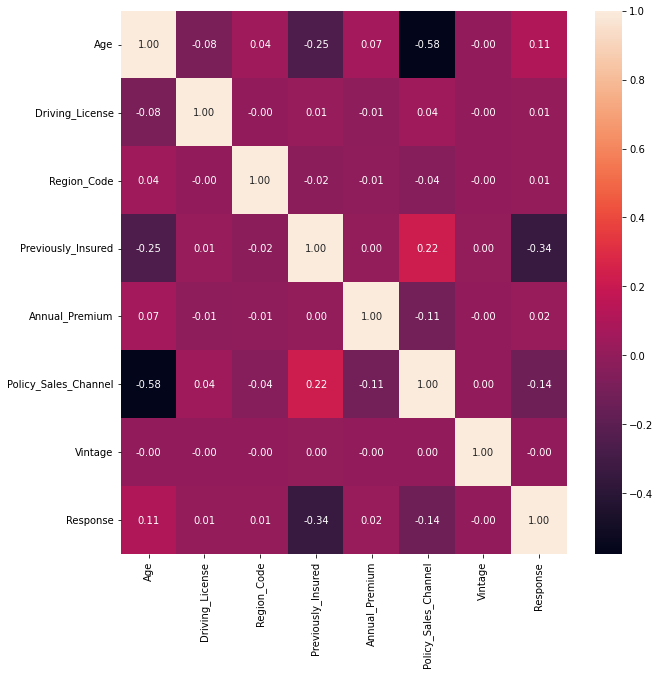

In [63]:
correlation = train[nums].corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation, annot=True, fmt='.2f')
plt.show()

# Preprocessing

## Handling Outlier

In [132]:
# hitung jumlah baris sebelum deteksi outlier
print(f'Jumlah baris sebelum memfilter outlier: {len(train[nums])}')

filtered_entries = np.array([True] * len(train[nums]))
for col in nums :
    Q1 = train[col].quantile(0.25)
    Q3 = train[col].quantile(0.75)
    IQR = Q3 - Q1
    low_limit = Q1 - (IQR * 1.5)
    high_limit = Q3 + (IQR * 1.5)

    filtered_entries = ((train[col] >= low_limit) & (train[col] <= high_limit)) & filtered_entries
    
train_clean = train[filtered_entries].reset_index()

# hitung jumlah baris setelah outlier
print(f'Jumlah baris setelah memfilter outlier: {len(train_clean)}')

Jumlah baris sebelum memfilter outlier: 381109
Jumlah baris setelah memfilter outlier: 324911


## Feature Encoding

In [133]:
#label encoding
train['Gender'].replace('Male',1,inplace=True) #male -> 1
train['Gender'].replace('Female',0,inplace=True)#female -> 0
train['Vehicle_Damage'].replace('Yes',1,inplace=True) #Yes -> 1
train['Vehicle_Damage'].replace('No',0,inplace=True)#No -> 0
train['Vehicle_Age'].replace('> 2 Years',0,inplace=True)# > 2 -> 2
train['Vehicle_Age'].replace('1-2 Year',1,inplace=True) # 1-2 -> 1
train['Vehicle_Age'].replace('< 1 Year',0,inplace=True)# < 1 -> 0

In [134]:
train.head()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage,Response
0,1,44,1,28.0,0,0,1,40454.0,26.0,217,1
1,1,76,1,3.0,0,1,0,33536.0,26.0,183,0
2,1,47,1,28.0,0,0,1,38294.0,26.0,27,1
3,1,21,1,11.0,1,0,0,28619.0,152.0,203,0
4,0,29,1,41.0,1,0,0,27496.0,152.0,39,0


## Scaling

In [135]:
X = train.drop(columns = 'Response')
y = train['Response']

In [136]:
X.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
count,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000,381109.000000
mean,0.540761,38.822584,0.997869,26.388807,0.458210,0.525613,0.504877,30564.389581,112.034295,154.347397
std,0.498336,15.511611,0.046110,13.229888,0.498251,0.499344,0.499977,17213.155057,54.203995,83.671304
min,0.000000,20.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2630.000000,1.000000,10.000000
25%,0.000000,25.000000,1.000000,15.000000,0.000000,0.000000,0.000000,24405.000000,29.000000,82.000000
50%,1.000000,36.000000,1.000000,28.000000,0.000000,1.000000,1.000000,31669.000000,133.000000,154.000000
75%,1.000000,49.000000,1.000000,35.000000,1.000000,1.000000,1.000000,39400.000000,152.000000,227.000000
max,1.000000,85.000000,1.000000,52.000000,1.000000,1.000000,1.000000,540165.000000,163.000000,299.000000


In [137]:
# Scaling dataframe
for col in X:
  scaler = StandardScaler()
  X[col] = scaler.fit_transform(X[col].values.reshape(len(X), 1))

In [138]:
X.describe()

,Gender,Age,Driving_License,Region_Code,Previously_Insured,Vehicle_Age,Vehicle_Damage,Annual_Premium,Policy_Sales_Channel,Vintage
count,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05,3.811090e+05
mean,9.687465e-17,-1.148103e-16,-9.322227e-16,1.230509e-17,7.849158e-17,-1.102238e-16,7.273056e-17,1.383391e-17,-7.644074e-17,-9.612889e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.085134e+00,-1.213453e+00,-2.164130e+01,-1.994638e+00,-9.196380e-01,-1.052609e+00,-1.009801e+00,-1.622853e+00,-2.048455e+00,-1.725174e+00
25%,-1.085134e+00,-8.911132e-01,4.620794e-02,-8.608404e-01,-9.196380e-01,-1.052609e+00,-1.009801e+00,-3.578308e-01,-1.531887e+00,-8.646631e-01
50%,9.215448e-01,-1.819661e-01,4.620794e-02,1.217845e-01,-9.196380e-01,9.500205e-01,9.902940e-01,6.417254e-02,3.867931e-01,-4.151927e-03
75%,9.215448e-01,6.561169e-01,4.620794e-02,6.508902e-01,1.087384e+00,9.500205e-01,9.902940e-01,5.133064e-01,7.373213e-01,8.683108e-01
max,9.215448e-01,2.976962e+00,4.620794e-02,1.935861e+00,1.087384e+00,9.500205e-01,9.902940e-01,2.960534e+01,9.402586e-01,1.728822e+00


## Train Test Split

In [139]:
# train test split sebelum modelling
X_train, X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2,
                                                  random_state = 42)

In [140]:
y_train.value_counts()

0    267700
1     37187
Name: Response, dtype: int64

# Modelling

In [141]:
y.value_counts()

0    334399
1     46710
Name: Response, dtype: int64

In [142]:
logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

LogisticRegression(random_state=42)

In [143]:
dct = DecisionTreeClassifier(random_state=42)
dct.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [144]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

KNeighborsClassifier()

In [145]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [146]:
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

XGBClassifier(random_state=42)

# Models Evalution

performa logreg:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
           1       0.00      0.00      0.00      9523

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222



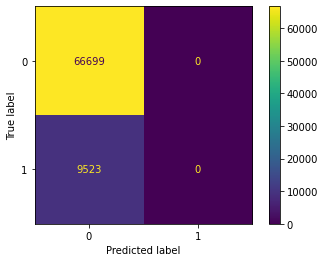


performa dct:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     66699
           1       0.29      0.31      0.30      9523

    accuracy                           0.82     76222
   macro avg       0.60      0.60      0.60     76222
weighted avg       0.82      0.82      0.82     76222



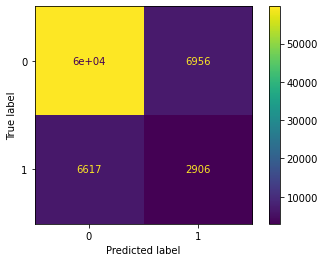


performa knn:
              precision    recall  f1-score   support

           0       0.89      0.95      0.92     66699
           1       0.34      0.18      0.23      9523

    accuracy                           0.85     76222
   macro avg       0.62      0.56      0.58     76222
weighted avg       0.82      0.85      0.83     76222



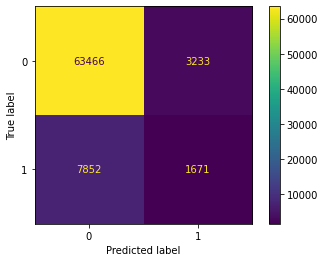


performa rfc:
              precision    recall  f1-score   support

           0       0.89      0.97      0.93     66699
           1       0.38      0.12      0.18      9523

    accuracy                           0.87     76222
   macro avg       0.63      0.55      0.55     76222
weighted avg       0.82      0.87      0.83     76222



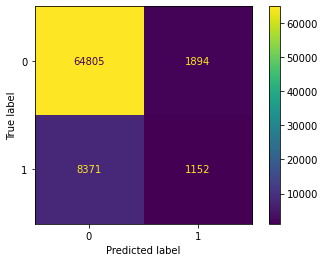


performa xgb:
              precision    recall  f1-score   support

           0       0.88      1.00      0.93     66699
           1       0.00      0.00      0.00      9523

    accuracy                           0.88     76222
   macro avg       0.44      0.50      0.47     76222
weighted avg       0.77      0.88      0.82     76222



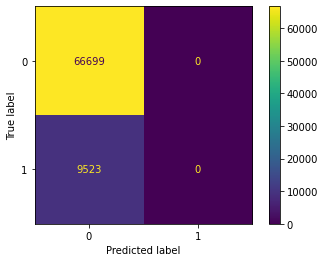

In [147]:
models = [logreg, dct, knn, rfc, xgb]
str_model = ['logreg', 'dct', 'knn', 'rfc', 'xgb']

for model, str_mod in zip(models, str_model):
  prediction = model.predict(X_test)
  cm = confusion_matrix(y_test, prediction,labels=model.classes_)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
  print(f'performa {str_mod}:')
  #print(confusion_matrix(y_test, prediction))
  print(classification_report(y_test, prediction))
  disp.plot()
  plt.show()
  print()

# Model validation

In [148]:
kfold = model_selection.KFold(n_splits=10,shuffle=True,
                              random_state=42)

In [149]:
for model,str_mod in zip(models, str_model):
  result = model_selection.cross_val_score(model, X, y, cv=kfold,
                                           scoring='f1')
  print(f'Model {str_mod}:')
  print('f1-score :%.2f%% (%.2f%%)' % (result.mean()*100, result.std()*100))

Model logreg:
f1-score :0.02% (0.02%)
Model dct:
f1-score :30.05% (0.62%)
Model knn:
f1-score :22.96% (0.40%)
Model rfc:
f1-score :18.17% (0.58%)
Model xgb:
f1-score :0.00% (0.00%)


# Hyperparameter Tuning


In [150]:
dct.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 42,
 'splitter': 'best'}

In [151]:
# specify the hyperparameter grid to search over
param_grid = {'max_depth': [1, 5, 10, 15, 20, 25, 30],
              'max_features': ['auto', 'sqrt', 'log2'],
              'min_samples_split': [2, 5, 10, 15, 20],
              'min_samples_leaf': [1, 2, 4, 6, 8]}

# create the grid search object
grid_search = GridSearchCV(dct, param_grid, scoring='f1', cv=5)

# fit the grid search to the data
grid_search.fit(X_train, y_train)

# get the best hyperparameters and the best cross-validation score
best_params = grid_search.best_params_
best_score = grid_search.best_score_


In [152]:
best_params

{'max_depth': 30,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

In [153]:
best_score

0.2532692327652286

In [154]:
# fungsi untuk evaluasi model
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    cm = confusion_matrix(y_test, predictions,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    # print classification report
    print(classification_report(test_labels, predictions))
    disp.plot()
    plt.show()
    print()

              precision    recall  f1-score   support

           0       0.90      0.90      0.90     66699
           1       0.29      0.31      0.30      9523

    accuracy                           0.82     76222
   macro avg       0.60      0.60      0.60     76222
weighted avg       0.82      0.82      0.82     76222



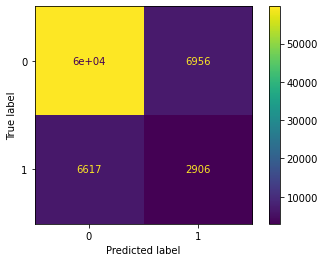


              precision    recall  f1-score   support

           0       0.89      0.92      0.91     66699
           1       0.30      0.24      0.27      9523

    accuracy                           0.84     76222
   macro avg       0.60      0.58      0.59     76222
weighted avg       0.82      0.84      0.83     76222



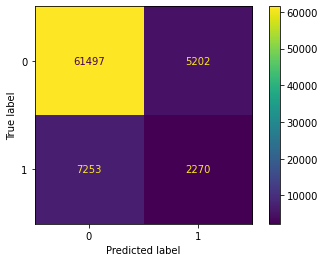

In [155]:
#evaluasi base model dct
base_dct = DecisionTreeClassifier(random_state = 42)
base_dct.fit(X_train, y_train)
base_accuracy = evaluate(base_dct, X_test, y_test)
# dengan best parameter dct
best_grid = grid_search.best_estimator_
random_accuracy = evaluate(best_grid, X_test, y_test)

# Features Importance

In [156]:
importances = best_grid.feature_importances_

In [157]:
features = pd.DataFrame({'feature': X_train.columns, 'importance': importances})

In [158]:
features

,feature,importance
0,Gender,0.013671
1,Age,0.157703
2,Driving_License,0.000580
3,Region_Code,0.105848
4,Previously_Insured,0.149973
5,Vehicle_Age,0.005734
6,Vehicle_Damage,0.029861
7,Annual_Premium,0.214981
8,Policy_Sales_Channel,0.062221
9,Vintage,0.259427


In [159]:
features = features.sort_values(by='importance', ascending=True)

In [160]:
features

,feature,importance
2,Driving_License,0.000580
5,Vehicle_Age,0.005734
0,Gender,0.013671
6,Vehicle_Damage,0.029861
8,Policy_Sales_Channel,0.062221
3,Region_Code,0.105848
4,Previously_Insured,0.149973
1,Age,0.157703
7,Annual_Premium,0.214981
9,Vintage,0.259427


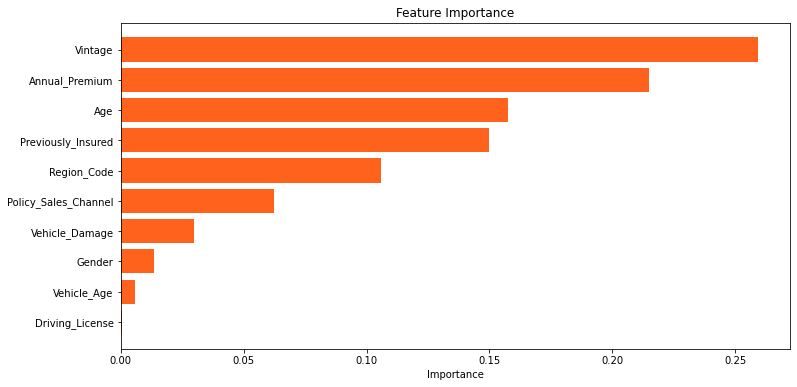

In [161]:
plt.subplots(figsize=(12,6))

plt.barh(features['feature'], features['importance'], color = '#fe621d')
plt.xlabel('Importance')
plt.title('Feature Importance')

# Show the plot
plt.show()

berdasarkan features importance, fitur vintage yang paling berpengaruh, lalu jumlah annual premium, kemudian age. sehingga perusahaan dapat menaruh fokus pada fitur - fitur tersebut.